## Build and train using nucleus7

As first tutorial let's build and train simple classification model:

* 2 convolutional layers
* one dense layer
* 10 classes
* softmax crossentropy as loss
* classification accuracy as metrics
* add last layer activations to summaries
* print statistics of training as callback
* data will be feeded using normal nc7.dataset.Dataset and read from tensorflow.keras.datasets.cifar10

### 1. Define and register classes

In [1]:
import os
import pprint
import logging

import numpy as np
import tensorflow as tf
from tensorflow import keras

import nucleus7 as nc7

cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

number_epochs = globals().get('number_epochs', 5)
number_of_iterations = globals().get('number_of_iterations')


logs_dir = 'project_01_logs'
if os.path.isdir(logs_dir):
    import shutil
    shutil.rmtree(logs_dir)

project_dir = os.path.join(logs_dir, "nc7_sample_project")
os.mkdir(logs_dir)
os.mkdir(project_dir)

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

In [2]:
class ConvPlugin(nc7.model.ModelPlugin):
    """
    Attributes
    ----------
    incoming_keys : list
        * conv_inputs : inputs to convolution
    generated_keys : list
        * conv_outputs : outputs of convolution
    """
    incoming_keys = ['conv_inputs']
    generated_keys = ['conv_outputs']

    def __init__(self, **kwargs):
        super(ConvPlugin, self).__init__(**kwargs)
        self.num_filters = kwargs.get('num_filters', [10, 20])

    def predict(self, conv_inputs):
        x = conv_inputs
        # e.g.:
        for filters in self.num_filters:
            conv = tf.layers.conv2d(x, filters, 3, activation=self.activation)
            x = tf.layers.max_pooling2d(conv, 2, 2)
        return {'conv_outputs': x}

In [3]:
class DensePlugin(nc7.model.ModelPlugin):
    incoming_keys = ['dense_inputs']
    generated_keys = ['logits']

    def __init__(self, **kwargs):
        super(DensePlugin, self).__init__(**kwargs)
        self.num_classes = kwargs.get('num_classes', 10)
    
    def create_keras_layers(self):
        dense_layer = tf.keras.layers.Dense(self.num_classes)
        self.dense_layer = self.add_keras_layer(dense_layer)

    def predict(self, dense_inputs):
        x = tf.layers.flatten(dense_inputs)
        x = self.dense_layer(x)
        return {'logits': x}

In [4]:
class SoftmaxLoss(nc7.model.ModelLoss):
    incoming_keys = ['labels', 'logits']
    generated_keys = ['loss']

    def __init__(self, **kwargs):
        super(SoftmaxLoss, self).__init__(**kwargs)

    def process(self, labels, logits):
        loss = tf.losses.sparse_softmax_cross_entropy(labels, logits)
        return {'loss': loss}

In [5]:
class ClassPostprocessor(nc7.model.ModelPostProcessor):
    incoming_keys = ["logits"]
    generated_keys = ["classes", "top_classes", "top_scores"]

    def __init__(self, top_k=5, **kwargs):
        super(ClassPostprocessor, self).__init__(**kwargs)
        # we would like to specify the top_k parameter also
        # during the inference, e.g. output results for different top_k values
        self.top_k = top_k

    def process(self, logits):
        top_k = self.add_default_placeholder(self.top_k, "top_k")
        top_k = tf.cast(top_k, tf.int32)
        top_k_scores, top_k_classes = tf.nn.top_k(logits, k=top_k)
        return {"classes": tf.argmax(logits, -1),
                "top_classes": top_k_classes,
                "top_scores": top_k_scores}

In [6]:
class AccuracyMetric(nc7.model.ModelMetric):
    incoming_keys = ['labels', 'predictions']
    generated_keys = ['scalar_accuracy', '_update_op']

    def __init__(self, **kwargs):
        super(AccuracyMetric, self).__init__(**kwargs)

    def process(self, labels, predictions):
        accuracy, update_op = tf.metrics.accuracy(labels, predictions)
        return {'scalar_accuracy': accuracy,
                'update_op': update_op}

In [7]:
class ActivationImageSaver(nc7.model.ModelSummary):
    incoming_keys = ['activations']
    generated_keys = ['image_activations']

    def __init__(self, **kwargs):
        super(ActivationImageSaver, self).__init__(**kwargs)

    def process(self, activations):
        summaries = {}
        for i in range(activations.get_shape().as_list()[-1]):
            summaries['image_activations_fm_{}'.format(i)] = activations[..., i:i+1]
        return summaries

Now main classes are defined and we can construct the Model

### 2. Create nucleotides

In [8]:
# We would like to use a new optimizer for CNN plugin, e.g. with scaled learning rate
optimization_config_cnn = nc7.optimization.create_and_validate_optimization_config(
    learning_rate_multiplier=0.1)

config_conv_plugin = {"name": 'conv_plugin',"inbound_nodes": ['dataset'],
                      "incoming_keys_mapping": {'dataset': {'image': 'conv_inputs'}},
                      "optimization_configs": optimization_config_cnn}
config_dense_plugin = {"name": 'dense_plugin',"inbound_nodes": ['conv_plugin'],
                       "incoming_keys_mapping": {'conv_plugin': {'conv_outputs': 'dense_inputs'}}}
config_classes_postprocessor = {"name": 'classes_pp', "inbound_nodes": ['dense_plugin']}
config_loss = {"name": 'loss', "inbound_nodes": ['dense_plugin', 'dataset']}
config_accuracy = {"name": 'accuracy_metric', "inbound_nodes": ['classes_pp', 'dataset'],
                   "incoming_keys_mapping": {'classes_pp': {'classes': 'predictions'}}}
config_summary = {"name": 'summary', "inbound_nodes": ['conv_plugin'],
                  "incoming_keys_mapping": {'conv_plugin': {'conv_outputs': 'activations'}}}

conv_plugin = ConvPlugin(**config_conv_plugin).build()
dense_plugin = DensePlugin(**config_dense_plugin).build()
classes_postprocessor = ClassPostprocessor(**config_classes_postprocessor).build()
loss = SoftmaxLoss(**config_loss).build()
accuracy = AccuracyMetric(**config_accuracy).build()
summary = ActivationImageSaver(**config_summary).build()

To use dropout, please provide the rate parameter
To use dropout, please provide the rate parameter


### 3. Create model

In [9]:
model = nc7.model.Model([conv_plugin, dense_plugin], loss,
                        postprocessors=classes_postprocessor,
                        metrics=accuracy,
                        summaries=summary).build()

### 4. Create datasets and callback

In [10]:
class CifarDataset(nc7.data.Dataset):
    generated_keys = ['image', 'labels']
    exclude_args_from_log = ["x", "y"]

    def __init__(self, x, y, **kwargs):
        super(CifarDataset, self).__init__(**kwargs)
        def generator():
            for x_, y_ in zip(x, y):
                yield {'image': x_.astype(np.float32)/255,
                       'labels': y_.astype(np.int64)}

        self._generator = generator

    def create_initial_data(self):
        data = tf.data.Dataset.from_generator(
            self._generator,
            output_types={'image': tf.float32, 'labels': tf.int64},
            output_shapes={'image': [32, 32, 3], 'labels': [1]})
        return data


In [11]:
class PrintCallback(nc7.coordinator.CoordinatorCallback):
    incoming_keys = ['loss', '_accuracy']

    def __init__(self, **kwargs):
        super(PrintCallback, self).__init__(**kwargs)

    def on_iteration_end(self, *, loss, accuracy=None):
        mode = self.mode
        iter_n = self.iteration_info.iteration_number
        time_exec = self.iteration_info.execution_time
        epoch = self.iteration_info.epoch_number
        log = 'mode: {} | epoch:  {:02d} | iter {:05d} | time_exec {:1.3f} | loss: {:1.5f}'.format(
            mode, epoch, iter_n, time_exec, loss)
        if accuracy is not None:
            log += ' | accuracy: {:1.5f}'.format(accuracy)
        print(log)

In [12]:
dataset_train = CifarDataset(x_train, y_train).build()
dataset_eval = CifarDataset(x_test, y_test).build()

### 5. Create training configs and Trainer

In [13]:
batch_size = {'train': 250,
              'eval': 500}
# number of samples to treat as a epoch
iterations_per_epoch = {'train': number_of_iterations or x_train.shape[0] // 500,
                        'eval': number_of_iterations or x_test.shape[0] // 1000}
save_train_summary_steps = 10

datasets = {'train': dataset_train,
            'eval': dataset_eval}
callbacks_train = [PrintCallback(inbound_nodes=['loss']).build()]
callbacks_eval = [PrintCallback(inbound_nodes=['loss', 'accuracy_metric'],
                                incoming_keys_mapping={
                                    'accuracy_metric': {'scalar_accuracy': 'accuracy'}
                                }).build()]

callbacks_handler_train = nc7.coordinator.CallbacksHandler(
    callbacks=callbacks_train).build()
callbacks_handler_eval = nc7.coordinator.CallbacksHandler(
    callbacks=callbacks_eval).build()

# use cpu and gpu if gpu is available and CPU otherwise
if nc7.utils.tf_utils.get_available_gpus():
    devices = ['/GPU:0', '/CPU:0']
else:
    devices = None

# or comment it and uncomment following line if you want to use multiple available GPUs or CPU
# devices = None

run_config = nc7.coordinator.configs.create_and_validate_trainer_run_config(
    batch_size=batch_size,
    iterations_per_epoch=iterations_per_epoch,
    num_epochs=number_epochs,
    devices=devices
)

save_config = nc7.coordinator.configs.create_and_validate_trainer_save_config(
    save_summary_steps=save_train_summary_steps
)

optimization_config = nc7.optimization.create_and_validate_optimization_config(
    optimizer_name="RMSPropOptimizer",
    learning_rate=0.01,
    decouple_regularization=True,
    is_global=True)

trainer = nc7.coordinator.Trainer(project_dir=project_dir,
                                  model=model,
                                  datasets=datasets,
                                  run_config=run_config,
                                  save_config=save_config,
                                  callbacks_handler_train=callbacks_handler_train,
                                  callbacks_handler_eval=callbacks_handler_eval,
                                  optimization_config=optimization_config)
trainer = trainer.build()

Model will have fixed input dimensions for inference! If you want to change it and if your model allows it, set inference_inputs_have_variable_shape = True
Following optional incoming keys to nucleotide loss have no input: 
	{'loss_mask': 'no description'}

Following optional incoming keys to nucleotide PrintCallback have no input: 
	{'accuracy': 'no description'}



INFO:tensorflow:Using config: {'_task_id': 0, '_model_dir': 'project_01_logs/nc7_sample_project/checkpoints', '_task_type': 'worker', '_train_distribute': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa11d8d4390>, '_protocol': None, '_session_config': gpu_options {
  allow_growth: true
}
allow_soft_placement: true
, '_save_checkpoints_steps': 100, '_experimental_distribute': None, '_is_chief': True, '_device_fn': None, '_service': None, '_save_checkpoints_secs': None, '_eval_distribute': None, '_num_ps_replicas': 0, '_master': '', '_num_worker_replicas': 1, '_log_step_count_steps': None, '_save_summary_steps': 0, '_evaluation_master': '', '_global_id_in_cluster': 0, '_tf_random_seed': 419, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000}


All checks passed, so the model build and all definitions were right :)

Lets draw the project DNA for train and evaluation:

Following optional incoming keys to nucleotide loss have no input: 
	{'loss_mask': 'no description'}

Following optional incoming keys to nucleotide PrintCallback have no input: 
	{'accuracy': 'no description'}

Following optional incoming keys to nucleotide loss have no input: 
	{'loss_mask': 'no description'}

/home/alexv/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


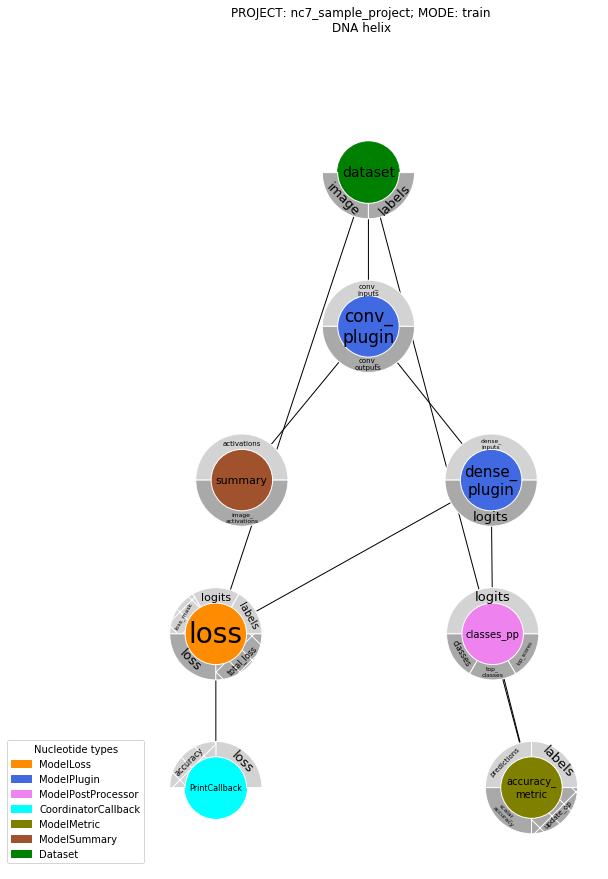

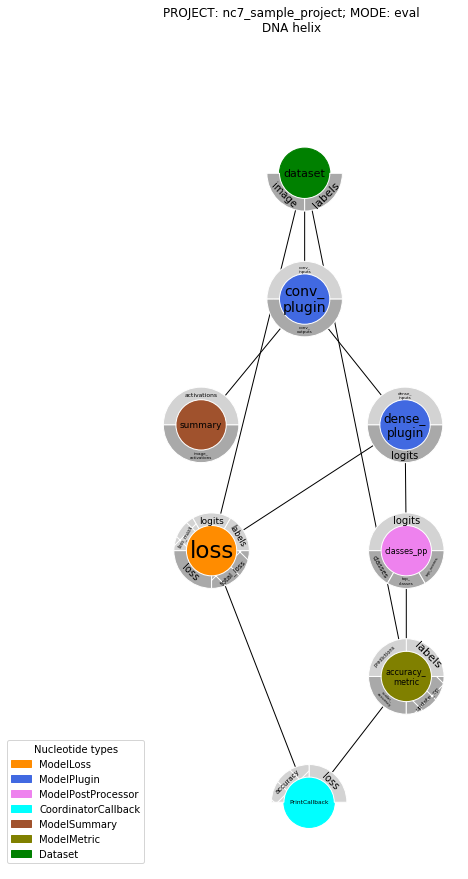

In [14]:
# uncomment following line if u want to have interactive plot (you may have wrong font sizes on figure redraw):
# %matplotlib agg
trainer.visualize_project_dna()

Let's take a look in generated project directory structure:

In [15]:
def print_dir_content():
    for root, subdirs, files in sorted(os.walk(project_dir)):
        if not files and subdirs:
            continue
        print('{}: \n\t\t{}'.format(root, files))

In [16]:
print_dir_content()

project_01_logs/nc7_sample_project: 
		['nucleus7_project.json']
project_01_logs/nc7_sample_project/checkpoints: 
		[]
project_01_logs/nc7_sample_project/saved_models: 
		[]
project_01_logs/nc7_sample_project/training/artifacts: 
		['dna_helix_train_(verbosity_0).pdf', 'dna_helix_eval_(verbosity_0).pdf']
project_01_logs/nc7_sample_project/training/callbacks: 
		[]
project_01_logs/nc7_sample_project/training/configs: 
		[]
project_01_logs/nc7_sample_project/training/summaries/eval: 
		[]
project_01_logs/nc7_sample_project/training/summaries/train: 
		[]


So, we have:

* nucleus7_project.json - file with meta project run information
* training - directory with training related stuff:

    * onfigs is empty, because we did not provided any configs, we created model by hand
    * summaries have 2 subdirectories - empty directory, which will be filled with summaries inside of train / eval subfolders once training will be started
    * callbacks have train and eval subdirectories, which are empty because no callbacks were called till now
    * artifacts is empty, but will be filled when the training starts
* checkpoints are also empty
* saved_models - it is a directory to store model exports after each evaluation run

Let´s take a look on nucleus7_project.json:

In [17]:
import json
with open(os.path.join(project_dir, 'nucleus7_project.json'), 'r') as f:
    print(json.load(f))

{'source_versions': [{'__main__': None, 'nucleus7': '0.6.10.dev41+0e9cb29'}], 'HOSTNAME': [None], 'PROJECT_NAME': 'nc7_sample_project', 'CLUSTER_SPEC': [{}], 'run_start_time': ['2019-05-20 16:26:55'], 'USER': ['alexv'], 'runs': ['chief:0']}


It is a dict now with rins key and list of run types inside. As we are running locally only, it has name `chief:0`.

### 6. Finally, run training

In [18]:
trainer.run()

INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps 100 or save_checkpoints_secs None.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.max_pooling2

mode: train | epoch:  01 | iter 00081 | time_exec 0.072 | loss: 2.27888
mode: train | epoch:  01 | iter 00082 | time_exec 0.076 | loss: 2.08012
mode: train | epoch:  01 | iter 00083 | time_exec 0.069 | loss: 2.04889
mode: train | epoch:  01 | iter 00084 | time_exec 0.072 | loss: 2.01893
mode: train | epoch:  01 | iter 00085 | time_exec 0.076 | loss: 1.99973
mode: train | epoch:  01 | iter 00086 | time_exec 0.086 | loss: 2.03150
mode: train | epoch:  01 | iter 00087 | time_exec 0.087 | loss: 1.97870
mode: train | epoch:  01 | iter 00088 | time_exec 0.074 | loss: 1.99230
mode: train | epoch:  01 | iter 00089 | time_exec 0.074 | loss: 2.00301
mode: train | epoch:  01 | iter 00090 | time_exec 0.074 | loss: 2.01452
mode: train | epoch:  01 | iter 00091 | time_exec 0.084 | loss: 2.04200
mode: train | epoch:  01 | iter 00092 | time_exec 0.072 | loss: 2.02364
mode: train | epoch:  01 | iter 00093 | time_exec 0.073 | loss: 2.02579
mode: train | epoch:  01 | iter 00094 | time_exec 0.071 | loss: 

Summary accuracy_metric/update_op will not be used in tensorboard as it does not have supported prefix in name!!! For further information see :obj:`ModelSummary`help
Summary accuracy_metric/update_op will not be used in tensorboard as it does not have supported prefix in name!!! For further information see :obj:`ModelSummary`help


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-05-20T14:27:11Z


/home/alexv/Projects/01_Code/nucleus7/nucleus7/model/model_handler.py:464: RuntimeWarning: Warning: summary with name accuracy_metric//update_op will not be added to tensorboard!
  metric_name, metric_value, self.max_outputs_tb)


INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from project_01_logs/nc7_sample_project/checkpoints/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
mode: eval | epoch:  01 | iter 00001 | time_exec 0.368 | loss: 1.97439 | accuracy: 0.00000
INFO:tensorflow:Evaluation [1/10]
mode: eval | epoch:  01 | iter 00002 | time_exec 0.138 | loss: 1.97379 | accuracy: 0.29600
INFO:tensorflow:Evaluation [2/10]
mode: eval | epoch:  01 | iter 00003 | time_exec 0.140 | loss: 1.96253 | accuracy: 0.30500
INFO:tensorflow:Evaluation [3/10]
mode: eval | epoch:  01 | iter 00004 | time_exec 0.154 | loss: 1.97688 | accuracy: 0.30000
INFO:tensorflow:Evaluation [4/10]
mode: eval | epoch:  01 | iter 00005 | time_exec 0.138 | loss: 1.96948 | accuracy: 0.29275
INFO:tensorflow:Evaluation [5/10]
mode: eval | epoch:  01 | iter 00006 | time_exec 0.150 | loss: 1

2019/05/20 16:27:14 INFO mlflow.tensorflow: Validating the specified Tensorflow model by attempting to load it in a new Tensorflow graph...


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from project_01_logs/nc7_sample_project/saved_models/1558362434/variables/variables


2019/05/20 16:27:14 INFO mlflow.tensorflow: Validation succeeded!


mode: train | epoch:  02 | iter 00000 | time_exec 3.493 | loss: 2.00247
mode: train | epoch:  02 | iter 00001 | time_exec 0.059 | loss: 1.94804
mode: train | epoch:  02 | iter 00002 | time_exec 0.061 | loss: 1.91999
mode: train | epoch:  02 | iter 00003 | time_exec 0.056 | loss: 1.85954
mode: train | epoch:  02 | iter 00004 | time_exec 0.052 | loss: 1.90211
mode: train | epoch:  02 | iter 00005 | time_exec 0.053 | loss: 1.90178
mode: train | epoch:  02 | iter 00006 | time_exec 0.054 | loss: 1.84978
mode: train | epoch:  02 | iter 00007 | time_exec 0.056 | loss: 1.91520
mode: train | epoch:  02 | iter 00008 | time_exec 0.055 | loss: 1.85324
mode: train | epoch:  02 | iter 00009 | time_exec 0.054 | loss: 1.89383
mode: train | epoch:  02 | iter 00010 | time_exec 0.057 | loss: 1.87960
mode: train | epoch:  02 | iter 00011 | time_exec 0.054 | loss: 1.89779
mode: train | epoch:  02 | iter 00012 | time_exec 0.056 | loss: 1.88871
mode: train | epoch:  02 | iter 00013 | time_exec 0.054 | loss: 

Summary accuracy_metric/update_op will not be used in tensorboard as it does not have supported prefix in name!!! For further information see :obj:`ModelSummary`help
Summary accuracy_metric/update_op will not be used in tensorboard as it does not have supported prefix in name!!! For further information see :obj:`ModelSummary`help


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-05-20T14:27:22Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from project_01_logs/nc7_sample_project/checkpoints/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
mode: eval | epoch:  02 | iter 00002 | time_exec 0.366 | loss: 1.62009 | accuracy: 0.00000
INFO:tensorflow:Evaluation [1/10]
mode: eval | epoch:  02 | iter 00003 | time_exec 0.149 | loss: 1.62730 | accuracy: 0.45600
INFO:tensorflow:Evaluation [2/10]
mode: eval | epoch:  02 | iter 00004 | time_exec 0.123 | loss: 1.60624 | accuracy: 0.45750
INFO:tensorflow:Evaluation [3/10]
mode: eval | epoch:  02 | iter 00005 | time_exec 0.152 | loss: 1.61823 | accuracy: 0.45367
INFO:tensorflow:Evaluation [4/10]
mode: eval | epoch:  02 | iter 00006 | time_exec 0.142 | loss: 1.57529 | accuracy: 0.44825
INFO:tensorflow:Evaluation [5/10]
mode: eval | epoch:  02 | iter 00007 | time_exec 0.1

2019/05/20 16:27:24 INFO mlflow.tensorflow: Validating the specified Tensorflow model by attempting to load it in a new Tensorflow graph...


INFO:tensorflow:Restoring parameters from project_01_logs/nc7_sample_project/saved_models/1558362444/variables/variables


2019/05/20 16:27:24 INFO mlflow.tensorflow: Validation succeeded!


mode: train | epoch:  03 | iter 00000 | time_exec 3.287 | loss: 1.66810
mode: train | epoch:  03 | iter 00001 | time_exec 0.052 | loss: 1.55914
mode: train | epoch:  03 | iter 00002 | time_exec 0.053 | loss: 1.61466
mode: train | epoch:  03 | iter 00003 | time_exec 0.055 | loss: 1.55479
mode: train | epoch:  03 | iter 00004 | time_exec 0.052 | loss: 1.58089
mode: train | epoch:  03 | iter 00005 | time_exec 0.054 | loss: 1.53705
mode: train | epoch:  03 | iter 00006 | time_exec 0.053 | loss: 1.54886
mode: train | epoch:  03 | iter 00007 | time_exec 0.054 | loss: 1.56695
mode: train | epoch:  03 | iter 00008 | time_exec 0.053 | loss: 1.51292
mode: train | epoch:  03 | iter 00009 | time_exec 0.055 | loss: 1.55817
mode: train | epoch:  03 | iter 00010 | time_exec 0.059 | loss: 1.63323
mode: train | epoch:  03 | iter 00011 | time_exec 0.052 | loss: 1.59856
mode: train | epoch:  03 | iter 00012 | time_exec 0.054 | loss: 1.51980
mode: train | epoch:  03 | iter 00013 | time_exec 0.054 | loss: 

Summary accuracy_metric/update_op will not be used in tensorboard as it does not have supported prefix in name!!! For further information see :obj:`ModelSummary`help
Summary accuracy_metric/update_op will not be used in tensorboard as it does not have supported prefix in name!!! For further information see :obj:`ModelSummary`help


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-05-20T14:27:32Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from project_01_logs/nc7_sample_project/checkpoints/model.ckpt-300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
mode: eval | epoch:  03 | iter 00003 | time_exec 0.382 | loss: 1.46633 | accuracy: 0.00000
INFO:tensorflow:Evaluation [1/10]
mode: eval | epoch:  03 | iter 00004 | time_exec 0.133 | loss: 1.45475 | accuracy: 0.50000
INFO:tensorflow:Evaluation [2/10]
mode: eval | epoch:  03 | iter 00005 | time_exec 0.148 | loss: 1.45623 | accuracy: 0.50400
INFO:tensorflow:Evaluation [3/10]
mode: eval | epoch:  03 | iter 00006 | time_exec 0.152 | loss: 1.45237 | accuracy: 0.50133
INFO:tensorflow:Evaluation [4/10]
mode: eval | epoch:  03 | iter 00007 | time_exec 0.141 | loss: 1.43374 | accuracy: 0.50225
INFO:tensorflow:Evaluation [5/10]
mode: eval | epoch:  03 | iter 00008 | time_exec 0.1

2019/05/20 16:27:35 INFO mlflow.tensorflow: Validating the specified Tensorflow model by attempting to load it in a new Tensorflow graph...


INFO:tensorflow:Restoring parameters from project_01_logs/nc7_sample_project/saved_models/1558362454/variables/variables


2019/05/20 16:27:35 INFO mlflow.tensorflow: Validation succeeded!


mode: train | epoch:  04 | iter 00000 | time_exec 3.348 | loss: 1.51098
mode: train | epoch:  04 | iter 00001 | time_exec 0.052 | loss: 1.40747
mode: train | epoch:  04 | iter 00002 | time_exec 0.053 | loss: 1.46770
mode: train | epoch:  04 | iter 00003 | time_exec 0.050 | loss: 1.40795
mode: train | epoch:  04 | iter 00004 | time_exec 0.053 | loss: 1.43994
mode: train | epoch:  04 | iter 00005 | time_exec 0.051 | loss: 1.49158
mode: train | epoch:  04 | iter 00006 | time_exec 0.052 | loss: 1.44862
mode: train | epoch:  04 | iter 00007 | time_exec 0.060 | loss: 1.49200
mode: train | epoch:  04 | iter 00008 | time_exec 0.052 | loss: 1.49094
mode: train | epoch:  04 | iter 00009 | time_exec 0.059 | loss: 1.51988
mode: train | epoch:  04 | iter 00010 | time_exec 0.053 | loss: 1.52563
mode: train | epoch:  04 | iter 00011 | time_exec 0.060 | loss: 1.49504
mode: train | epoch:  04 | iter 00012 | time_exec 0.053 | loss: 1.43435
mode: train | epoch:  04 | iter 00013 | time_exec 0.054 | loss: 

Summary accuracy_metric/update_op will not be used in tensorboard as it does not have supported prefix in name!!! For further information see :obj:`ModelSummary`help
Summary accuracy_metric/update_op will not be used in tensorboard as it does not have supported prefix in name!!! For further information see :obj:`ModelSummary`help


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-05-20T14:27:42Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from project_01_logs/nc7_sample_project/checkpoints/model.ckpt-400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
mode: eval | epoch:  04 | iter 00004 | time_exec 0.381 | loss: 1.39210 | accuracy: 0.00000
INFO:tensorflow:Evaluation [1/10]
mode: eval | epoch:  04 | iter 00005 | time_exec 0.165 | loss: 1.37521 | accuracy: 0.52100
INFO:tensorflow:Evaluation [2/10]
mode: eval | epoch:  04 | iter 00006 | time_exec 0.135 | loss: 1.37974 | accuracy: 0.52800
INFO:tensorflow:Evaluation [3/10]
mode: eval | epoch:  04 | iter 00007 | time_exec 0.154 | loss: 1.37215 | accuracy: 0.52767
INFO:tensorflow:Evaluation [4/10]
mode: eval | epoch:  04 | iter 00008 | time_exec 0.151 | loss: 1.35729 | accuracy: 0.52700
INFO:tensorflow:Evaluation [5/10]
mode: eval | epoch:  04 | iter 00009 | time_exec 0.1

2019/05/20 16:27:45 INFO mlflow.tensorflow: Validating the specified Tensorflow model by attempting to load it in a new Tensorflow graph...


INFO:tensorflow:Restoring parameters from project_01_logs/nc7_sample_project/saved_models/1558362465/variables/variables


2019/05/20 16:27:45 INFO mlflow.tensorflow: Validation succeeded!


mode: train | epoch:  05 | iter 00000 | time_exec 3.252 | loss: 1.38347
mode: train | epoch:  05 | iter 00001 | time_exec 0.052 | loss: 1.35818
mode: train | epoch:  05 | iter 00002 | time_exec 0.052 | loss: 1.35227
mode: train | epoch:  05 | iter 00003 | time_exec 0.051 | loss: 1.32161
mode: train | epoch:  05 | iter 00004 | time_exec 0.058 | loss: 1.40452
mode: train | epoch:  05 | iter 00005 | time_exec 0.054 | loss: 1.36234
mode: train | epoch:  05 | iter 00006 | time_exec 0.053 | loss: 1.40747
mode: train | epoch:  05 | iter 00007 | time_exec 0.055 | loss: 1.38340
mode: train | epoch:  05 | iter 00008 | time_exec 0.054 | loss: 1.42899
mode: train | epoch:  05 | iter 00009 | time_exec 0.054 | loss: 1.45224
mode: train | epoch:  05 | iter 00010 | time_exec 0.058 | loss: 1.52207
mode: train | epoch:  05 | iter 00011 | time_exec 0.056 | loss: 1.49827
mode: train | epoch:  05 | iter 00012 | time_exec 0.052 | loss: 1.33116
mode: train | epoch:  05 | iter 00013 | time_exec 0.055 | loss: 

Summary accuracy_metric/update_op will not be used in tensorboard as it does not have supported prefix in name!!! For further information see :obj:`ModelSummary`help
Summary accuracy_metric/update_op will not be used in tensorboard as it does not have supported prefix in name!!! For further information see :obj:`ModelSummary`help


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-05-20T14:27:53Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from project_01_logs/nc7_sample_project/checkpoints/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
mode: eval | epoch:  05 | iter 00005 | time_exec 0.349 | loss: 1.32616 | accuracy: 0.00000
INFO:tensorflow:Evaluation [1/10]
mode: eval | epoch:  05 | iter 00006 | time_exec 0.173 | loss: 1.31221 | accuracy: 0.55700
INFO:tensorflow:Evaluation [2/10]
mode: eval | epoch:  05 | iter 00007 | time_exec 0.146 | loss: 1.30742 | accuracy: 0.54900
INFO:tensorflow:Evaluation [3/10]
mode: eval | epoch:  05 | iter 00008 | time_exec 0.144 | loss: 1.29372 | accuracy: 0.54933
INFO:tensorflow:Evaluation [4/10]
mode: eval | epoch:  05 | iter 00009 | time_exec 0.160 | loss: 1.29182 | accuracy: 0.55150
INFO:tensorflow:Evaluation [5/10]
mode: eval | epoch:  05 | iter 00001 | time_exec 0.1

2019/05/20 16:27:55 INFO mlflow.tensorflow: Validating the specified Tensorflow model by attempting to load it in a new Tensorflow graph...


INFO:tensorflow:Restoring parameters from project_01_logs/nc7_sample_project/saved_models/1558362475/variables/variables


2019/05/20 16:27:55 INFO mlflow.tensorflow: Validation succeeded!


mode: train | epoch:  06 | iter 00000 | time_exec 3.414 | loss: 1.32990
INFO:tensorflow:Loss for final step: 1.3299044.


As you can see, training goes and converges and prints what we wanted :)
Let's take a look on project directory now:

In [19]:
print_dir_content()

project_01_logs/nc7_sample_project: 
		['nucleus7_project.json']
project_01_logs/nc7_sample_project/checkpoints: 
		['model.ckpt-300.index', 'model.ckpt-100.meta', 'model.ckpt-400.index', 'model.ckpt-200.meta', 'model.ckpt-500.meta', 'model.ckpt-500.data-00002-of-00003', 'model.ckpt-300.meta', 'model.ckpt-300.data-00000-of-00003', 'checkpoint', 'graph.pbtxt', 'model.ckpt-300.data-00001-of-00003', 'model.ckpt-500.data-00001-of-00003', 'model.ckpt-100.data-00000-of-00003', 'model.ckpt-200.index', 'events.out.tfevents.1558362420.Vorobiov-UBUNTU', 'model.ckpt-200.data-00002-of-00003', 'model.ckpt-100.index', 'model.ckpt-100.data-00002-of-00003', 'model.ckpt-500.data-00000-of-00003', 'model.ckpt-100.data-00001-of-00003', 'model.ckpt-400.data-00001-of-00003', 'model.ckpt-200.data-00001-of-00003', 'model.ckpt-500.index', 'model.ckpt-400.data-00000-of-00003', 'model.ckpt-200.data-00000-of-00003', 'model.ckpt-400.data-00002-of-00003', 'graph_inference.meta', 'input_output_names.json', 'model.ck

Now there are some new files inside:
* checkpoints - checkpoints after each epoch; eval directory has some file inside, but it is an issue with tensorflow Estimator, so it has nothing interesting inside
    * graph_inference.meta - tf meta inference graph
    * input_output_names.json - json with input node names and output node names and their shapes
* training:
    * summaries have summaries for eval and train modes - take a look on then with tensorboard
    * artifacts have bump of the used configs for the training
* saved_models:
    * {export_dir}:
        * eval_result.json - evaluation metrics for this export
        * model.info - file with global_step inside
        * other files are stored in tensorflos SavedModel format; you can use saved_model_cli from tensorflow to inspect it or use it for inference


### Summary

I discribed how to create your own nucleotides and how to build and train an nucleus7 model.

There is also a CLI interface (bin/nc7-train), which provides you the possibility to use already defined nucleotides / genes with their configuration json files for your project and run it with only one file. This method is **preferred**, as it is more cosine and you do not need to create multiple .py files, only json configurations.

There is also a **ncgenes7** repo with bunch of already implemented genes for multiple tasks. Check it out!

Check next tutorial how to use this model for inference!